<a href="https://colab.research.google.com/github/Luana-lrb/LIPAI_Python/blob/main/onboarding/src/semana_13/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementação U-Net**

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [2]:
!pip install albumentations==1.4.0 opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
IMG_DIR = "/content/drive/MyDrive/dataset_displasia/images_original"
MASK_DIR = "/content/drive/MyDrive/dataset_displasia/gold_standart"

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.model_selection import train_test_split

### **Bloco de Convolução**

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batchnorm=True):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels) if batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels) if batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

### **Encoder**

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_channels, batchnorm=True):
        super().__init__()
        self.blocks = nn.ModuleList([
            ConvBlock(in_channels, 64, batchnorm),
            ConvBlock(64, 128, batchnorm),
            ConvBlock(128, 256, batchnorm),
            ConvBlock(256, 512, batchnorm),
        ])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        skips = []
        for block in self.blocks:
            x = block(x)
            skips.append(x)
            x = self.pool(x)
        return x, skips


### **Bottleneck**

In [8]:
class Bottleneck(nn.Module):
    def __init__(self, batchnorm=True):
        super().__init__()
        self.block = ConvBlock(512, 1024, batchnorm)

    def forward(self, x):
        return self.block(x)

### **UpBlock**

In [9]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, batchnorm=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = ConvBlock(out_ch * 2, out_ch, batchnorm)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

### **Decoder**

In [10]:
class Decoder(nn.Module):
    def __init__(self, batchnorm=True):
        super().__init__()
        self.blocks = nn.ModuleList([
            UpBlock(1024, 512, batchnorm),
            UpBlock(512, 256, batchnorm),
            UpBlock(256, 128, batchnorm),
            UpBlock(128, 64, batchnorm),
        ])
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, skips):
        skips = skips[::-1]
        for i in range(len(self.blocks)):
            x = self.blocks[i](x, skips[i])
        return self.final(x)

### **U-NET COMPLETA**

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.bottleneck = Bottleneck()
        self.decoder = Decoder()

    def forward(self, x):
        x, skips = self.encoder(x)
        x = self.bottleneck(x)
        return self.decoder(x, skips)

### **Dataset**

In [22]:
class OralDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            aug = self.transform(image=np.array(image), mask=np.array(mask))
            image = aug["image"]
            mask = aug["mask"]

        image = image.float() / 255.0
        mask = (mask > 0).float().unsqueeze(0)

        return image, mask


In [13]:
def build_samples(img_root, mask_root):
    samples = []

    for cls in ["healthy", "severe"]:
        img_dir = os.path.join(img_root, cls)
        mask_dir = os.path.join(mask_root, cls)

        imgs = sorted(os.listdir(img_dir))
        masks = sorted(os.listdir(mask_dir))

        for img, mask in zip(imgs, masks):
            samples.append((
                os.path.join(img_dir, img),
                os.path.join(mask_dir, mask)
            ))

    return samples

In [14]:
def split_data(samples, seed=42):

      if len(samples) == 0:
          raise ValueError("Samples vazio")

      imgs, masks = zip(*samples)

      # 70% treino+val e 30% teste
      img_tv, img_test, mask_tv, mask_test = train_test_split(
          imgs, masks,
          test_size= 0.3,
          random_state=seed,
          shuffle=True
      )

      # dentro dos 70% ( 80% treino e 20% val)
      img_train, img_val, mask_train, mask_val = train_test_split(
          img_tv, mask_tv,
          test_size=0.2,
          random_state=seed,
          shuffle=True
      )

      train = list(zip(img_train, mask_train))
      val   = list(zip(img_val, mask_val))
      test  = list(zip(img_test, mask_test))

      return train, val, test

### **Aumento de Dados**

In [15]:
transform_no_aug = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

transform_aug = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    ToTensorV2()
])

### **Métricas**

In [16]:
def metrics(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).long()

    tp = ((pred == 1) & (target == 1)).sum().float()
    fp = ((pred == 1) & (target == 0)).sum().float()
    fn = ((pred == 0) & (target == 1)).sum().float()
    tn = ((pred == 0) & (target == 0)).sum().float()

    acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)

    return acc.item(), dice.item(), iou.item()

### **Treinamento**

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [18]:
def evaluate(model, loader, device):
    model.eval()
    accs, dices, ious = [], [], []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            out = model(imgs)

            acc, dice, iou = metrics(out, masks)
            accs.append(acc)
            dices.append(dice)
            ious.append(iou)

    return np.mean(accs), np.mean(dices), np.mean(ious)


In [19]:
def train_validate_test( train_loader, val_loader, test_loader, epochs=10, lr=1e-4 ):

    model = UNet(in_channels=3).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_dice = -1
    best_metrics_val = None
    best_epoch = 0
    best_model_state = None

    for epoch in range(epochs):
        # ----- treino -----
        model.train()
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, masks)
            loss.backward()
            optimizer.step()

        # ----- validação -----
        val_acc, val_dice, val_iou = evaluate(model, val_loader, device)

        print(f"Epoch {epoch+1}/{epochs}, Val ACC:  {val_acc:.4f}, Val DICE: {val_dice:.4f}, Val IoU:  {val_iou:.4f}\n")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            best_metrics_val = (val_acc, val_dice, val_iou)
            best_epoch = epoch + 1
            best_model_state = model.state_dict().copy()

    print(f"Melhor época: {best_epoch} (Val DICE = {best_val_dice:.4f})")

    model.load_state_dict(best_model_state)
    # ----- teste -----
    test_acc, test_dice, test_iou = evaluate(model, test_loader, device)

    return {
        "val":  best_metrics_val,
        "test": (test_acc, test_dice, test_iou),
        "model": model
    }


In [20]:
samples = build_samples(IMG_DIR, MASK_DIR)

train_samples, val_samples, test_samples = split_data(samples)

### Sem Augmentation

In [23]:
train_ds = OralDataset(train_samples, transform=transform_no_aug)
val_ds   = OralDataset(val_samples, transform=transform_no_aug)
test_ds  = OralDataset(test_samples, transform=transform_no_aug)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=4, shuffle=False)

results_no_aug = train_validate_test(train_loader, val_loader, test_loader)

Epoch 1/10, Val ACC:  0.7791, Val DICE: 0.5543, Val IoU:  0.3850

Epoch 2/10, Val ACC:  0.8352, Val DICE: 0.7347, Val IoU:  0.5821

Epoch 3/10, Val ACC:  0.8431, Val DICE: 0.7419, Val IoU:  0.5914

Epoch 4/10, Val ACC:  0.8350, Val DICE: 0.7513, Val IoU:  0.6026

Epoch 5/10, Val ACC:  0.8619, Val DICE: 0.7587, Val IoU:  0.6121

Epoch 6/10, Val ACC:  0.8562, Val DICE: 0.7327, Val IoU:  0.5807

Epoch 7/10, Val ACC:  0.8606, Val DICE: 0.7627, Val IoU:  0.6172

Epoch 8/10, Val ACC:  0.8633, Val DICE: 0.7619, Val IoU:  0.6169

Epoch 9/10, Val ACC:  0.8392, Val DICE: 0.7379, Val IoU:  0.5868

Epoch 10/10, Val ACC:  0.8437, Val DICE: 0.6878, Val IoU:  0.5289

Melhor época: 7 (Val DICE = 0.7627)


### Com Augmentation

In [24]:
train_ds = OralDataset(train_samples, transform=transform_aug)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

results_aug = train_validate_test(train_loader, val_loader, test_loader)

Epoch 1/10, Val ACC:  0.7565, Val DICE: 0.4139, Val IoU:  0.2622

Epoch 2/10, Val ACC:  0.8255, Val DICE: 0.7134, Val IoU:  0.5549

Epoch 3/10, Val ACC:  0.8349, Val DICE: 0.7348, Val IoU:  0.5822

Epoch 4/10, Val ACC:  0.8423, Val DICE: 0.7526, Val IoU:  0.6041

Epoch 5/10, Val ACC:  0.8560, Val DICE: 0.7529, Val IoU:  0.6050

Epoch 6/10, Val ACC:  0.8590, Val DICE: 0.7477, Val IoU:  0.5980

Epoch 7/10, Val ACC:  0.8582, Val DICE: 0.7592, Val IoU:  0.6126

Epoch 8/10, Val ACC:  0.8672, Val DICE: 0.7772, Val IoU:  0.6369

Epoch 9/10, Val ACC:  0.8647, Val DICE: 0.7571, Val IoU:  0.6105

Epoch 10/10, Val ACC:  0.8664, Val DICE: 0.7817, Val IoU:  0.6422

Melhor época: 10 (Val DICE = 0.7817)


### **Comparação de resultado**

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

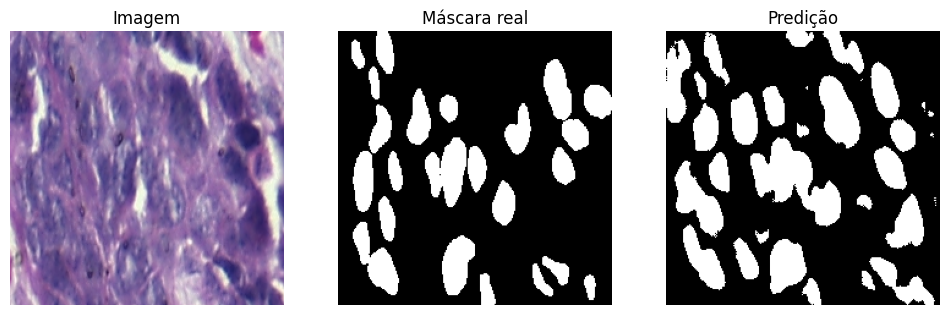

In [25]:
model = results_aug['model']
model.eval()

i = np.random.randint(len(test_ds))
x, y = test_ds[i]

with torch.no_grad():
    pred = model(x.unsqueeze(0).to(device))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(x.permute(1,2,0).cpu())
plt.title("Imagem")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(y[0], cmap="gray")
plt.title("Máscara real")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow((torch.sigmoid(pred)[0,0] > 0.5).cpu(), cmap="gray")
plt.title("Predição")
plt.axis("off")
